## Attribution

This section covers more details on attributions using the fitted model object:

1. meaning of the output dataframes
2. what-if scenario generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from karpiu.models import MMM
from karpiu.explainability import AttributorGamma as Attributor

pd.set_option("display.float_format", lambda x: "%.3f" % x)
print(karpiu.__version__)

In [2]:
%load_ext autoreload
%autoreload 2

### Data and Model

To star with, we need a fitted MMM and we can reuse the one we fitted from the previous `Quickstart` section.

In [3]:
with open("./resource/seasonal/model.pkl", "rb") as f:
    mmm = pickle.load(f)

After that, users need to specify the interval for the attribution period.

### Attribution on Historic Performance

In [4]:
ATTR_START = "2020-01-01"
ATTR_END = "2020-03-31"

spend_cols = mmm.get_spend_cols()
channels = ["organic"] + spend_cols

In [5]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.04583,0.04006,0.05170,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.06051,0.05616,0.06488,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.17444,0.16710,0.18166,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.09445,0.08907,0.09999,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.06686,0.06233,0.07167,1.00000,0.00000,0.00000,0.10000
5,s7_fs_cos1,Regular,0.18136,0.17781,0.18502,1.00000,0.00000,0.00000,0.30000
6,s7_fs_cos2,Regular,0.10155,0.09786,0.10518,1.00000,0.00000,0.00000,0.30000
7,s7_fs_sin1,Regular,-0.62595,-0.62962,-0.62236,0.00000,1.00000,0.00000,0.30000
8,s7_fs_sin2,Regular,0.00593,0.00272,0.00937,0.99500,0.00500,0.00000,0.30000
9,s365.25_fs_cos1,Regular,-0.09979,-0.10726,-0.09273,0.00000,1.00000,0.00000,0.30000


 Then users can utilize `Attributor.make_attribution()` to derive attribution summary. There are four output dataframes here:

 1. `activities_attr_df`: attribution against sales date
 2. `spend_attr_df`: attribution against spend date
 3. `spend_df`: spend against spend date (original input)
 4. `cost_df`: cost per sales against spend date (output item 3 divided by output item 2)

 The difference between output item 1 and output item 2 is that item 1 describes attribution against the date the sales actually happened while item 2 is from the accounting prospective -- it describes the attribution against the date when the spend tied to such attribution happened.

 In the case where there is no adstock in the model, one should expect these two output items are identical.

In [8]:
%%time
attr_obj = Attributor(mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()

2023-12-10 14:24:01 - karpiu-planning - INFO - Full calculation start=2020-01-01 and end=2020-03-31
2023-12-10 14:24:01 - karpiu-planning - INFO - Attribution start=2020-01-01 and end=2020-03-31


CPU times: user 55.1 ms, sys: 1.95 ms, total: 57 ms
Wall time: 56.1 ms


In [10]:
from karpiu.plots import (
    plot_attribution_with_time,
    plot_attribution_waterfall,
    ColorConstants,
)

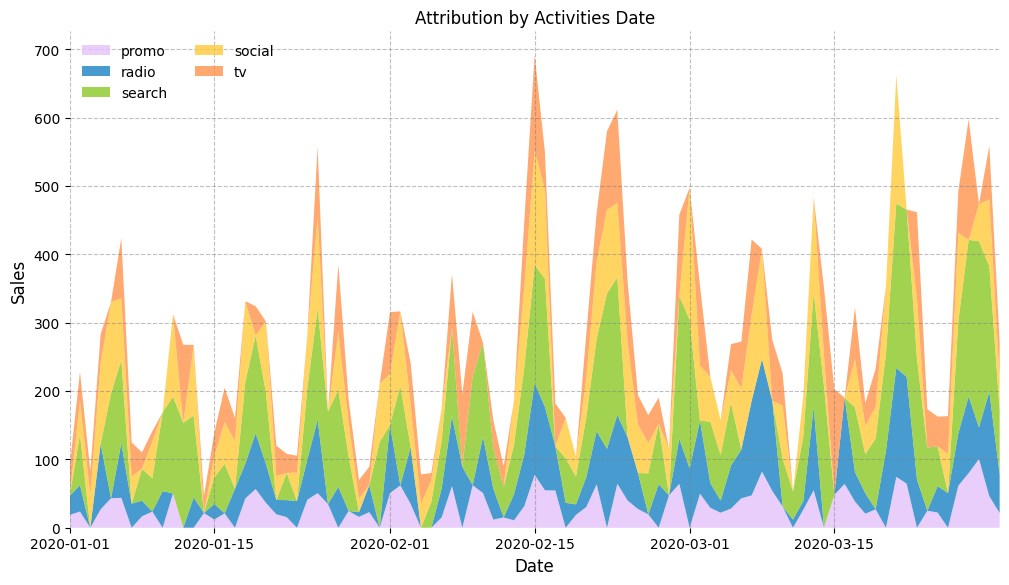

In [11]:
ax = plot_attribution_with_time(
    model=mmm,
    attr_df=activities_attr_df,
    figsize=(10, 5.5),
    colors=ColorConstants.RAINBOW_SIX,
    show=False,
    dt_col="date",
    include_organic=False,
)
ax.set_title("Attribution by Activities Date", fontdict={"fontsize": 12})
ax.set_xlabel("Date", fontdict={"fontsize": 12})
ax.set_ylabel("Sales", fontdict={"fontsize": 12})

fig = ax.figure
fig

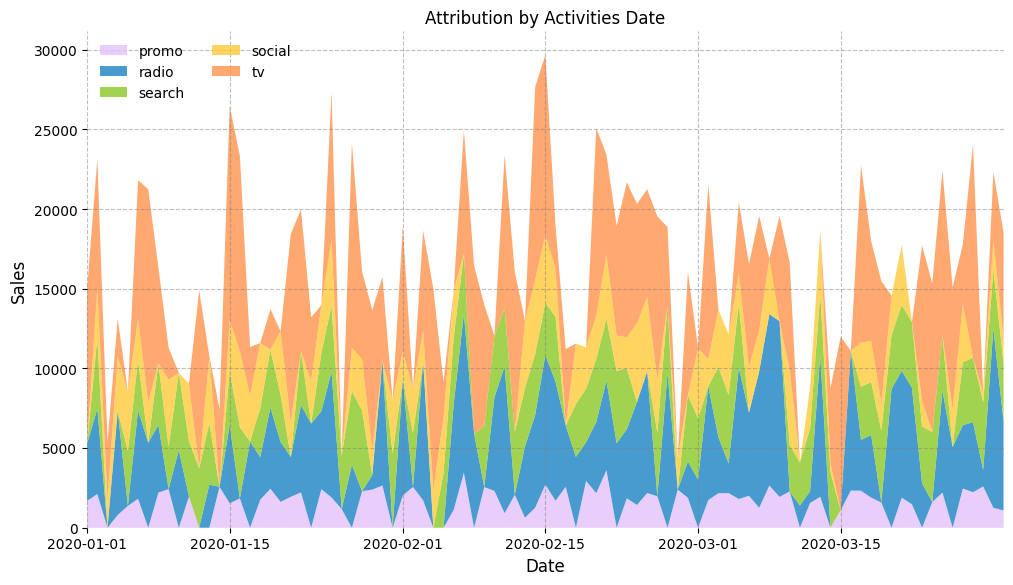

In [12]:
ax = plot_attribution_with_time(
    model=mmm,
    attr_df=spend_df,
    figsize=(10, 5.5),
    colors=ColorConstants.RAINBOW_SIX,
    show=False,
    dt_col="date",
    include_organic=False,
)
ax.set_title("Attribution by Activities Date", fontdict={"fontsize": 12})
ax.set_xlabel("Date", fontdict={"fontsize": 12})
ax.set_ylabel("Sales", fontdict={"fontsize": 12})

fig = ax.figure
fig

### Attribution on Future Performance with Model Prediction

Users can also use attribution on future predictions from the model. This simply means making attribution on predicted response since the actual response has not been observed yet. The first step is to create the data frame contains future information needed to make prediction. The package offers a utilities to make future features by rolling mean.

In [13]:
from karpiu.utils import insert_events, extend_ts_features

N_PERIODS = 180
df = mmm.get_raw_df()
future_df = df[["date"] + spend_cols]
future_df = extend_ts_features(
    future_df, n_periods=N_PERIODS, date_col="date", rolling_window=30
)
future_df, event_cols = insert_events(future_df, date_col="date", country="US")
future_df.tail(10)

,date,promo,radio,search,social,tv,new-years-day,martin-luther-king-jr-day,washingtons-birthday,memorial-day,...,labor-day,columbus-day,veterans-day,thanksgiving,christmas-day,independence-day-observed,juneteenth-national-independence-day-observed,juneteenth-national-independence-day,christmas-day-observed,new-years-day-observed
1265,2022-06-19,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1266,2022-06-20,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1267,2022-06-21,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1268,2022-06-22,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1269,2022-06-23,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1270,2022-06-24,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1271,2022-06-25,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1272,2022-06-26,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1273,2022-06-27,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1274,2022-06-28,1690.50000,4696.00000,3925.00000,2149.00000,4237.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then the next step is to make prediction and relabel it as the response column.

In [14]:
pred_df = mmm.predict(future_df)
expected_sales = np.concatenate(
    [df["sales"].values, pred_df["prediction"].values[-N_PERIODS:]]
)
future_df["sales"] = expected_sales

In [15]:
future_df["date"].max()

Timestamp('2022-06-28 00:00:00')

With the extended dataframe, users can input it into the Attributor as external data and follow the previous syntax to make attribution.

In [16]:
ATTR_START = "2022-01-01"
ATTR_END = "2022-04-30"

attr_obj = Attributor(mmm, start=ATTR_START, end=ATTR_END, df=future_df)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()

2023-12-10 14:25:21 - karpiu-planning - INFO - Full calculation start=2022-01-01 and end=2022-04-30
2023-12-10 14:25:21 - karpiu-planning - INFO - Attribution start=2022-01-01 and end=2022-04-30


In [17]:
spend_attr_df.tail(10)

,date,organic,promo,radio,search,social,tv
110,2022-04-21,783.00278,38.19469,66.34988,128.10007,73.55632,52.24379
111,2022-04-22,1352.58511,65.97879,114.61499,221.28432,127.06364,90.24766
112,2022-04-23,1823.88419,88.96865,154.55180,298.38934,171.33810,121.69384
113,2022-04-24,1989.99997,97.07174,168.62808,325.56606,186.94323,132.77748
114,2022-04-25,1478.42374,72.11717,125.27827,241.87165,138.88508,98.64391
115,2022-04-26,747.46951,36.46139,63.33887,122.28678,70.21828,49.87292
116,2022-04-27,522.77239,25.50072,44.29854,85.52610,49.10993,34.88060
117,2022-04-28,751.09550,36.63826,63.64613,122.88000,70.55891,50.11486
118,2022-04-29,1297.29147,63.28158,109.92953,212.23823,121.86928,86.55834
119,2022-04-30,1749.32826,85.33183,148.23410,286.19191,164.33421,116.71930
